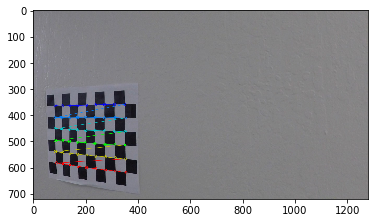

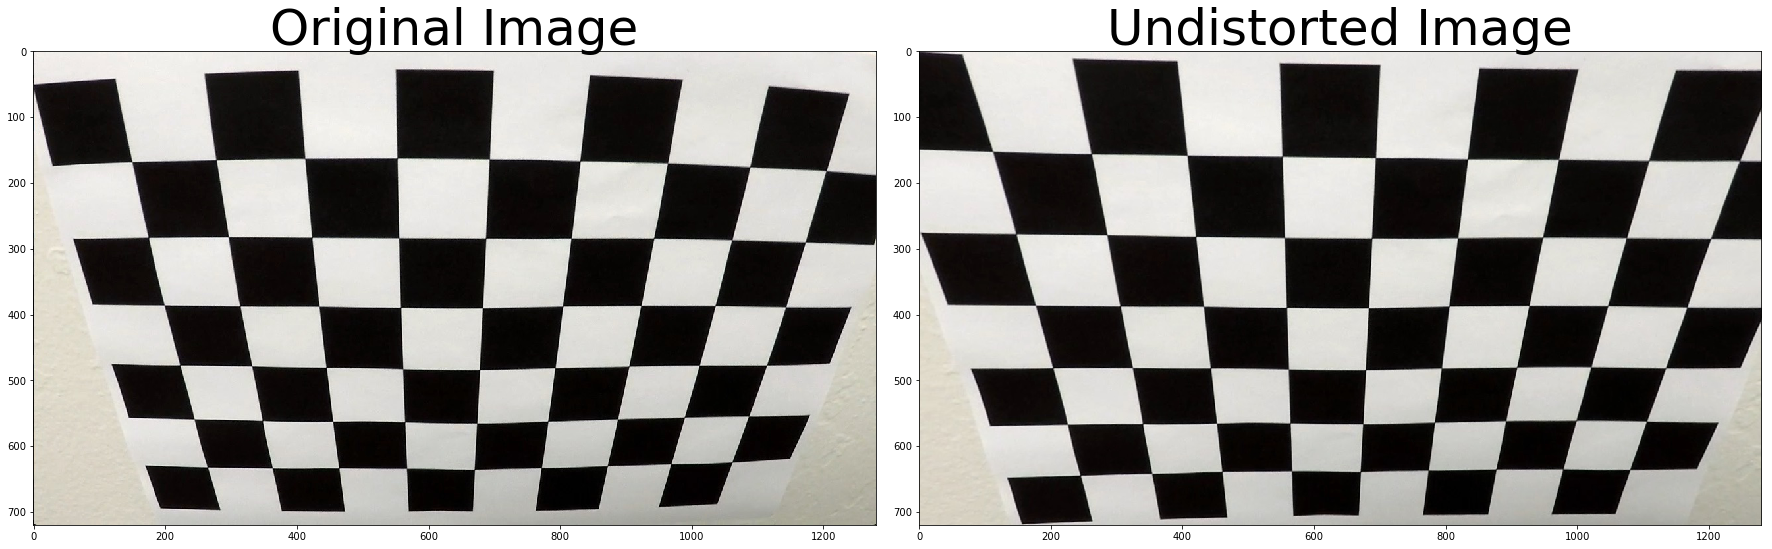

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
# chessboard corner
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
testimg = 'camera_cal/calibration2.jpg'
test = mpimg.imread(testimg)
undist = cv2.undistort(test,mtx,dist,mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [2]:
#  fuction definition
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel=np.fabs(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient=='y':
        sobel=np.fabs(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    abssobel=np.uint8(255*sobel/np.max(sobel))
    mask=np.zeros_like(abssobel)
    mask[(abssobel>=thresh[0])&(abssobel<=thresh[1])]=1
    return mask


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output



def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output



def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


def img_roi(img):
    xsize = img.shape[1]
    ysize = img.shape[0]
    region_select = np.copy(img)
    left_bottom = [250, ysize-100]
    right_bottom = [xsize-250, ysize-100]
    apex1 = [xsize/2-40, ysize/2+70]
    apex2 = [xsize/2+40, ysize/2+70]
    fit_left = np.polyfit((left_bottom[0], apex1[0]), (left_bottom[1], apex1[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex2[0]), (right_bottom[1], apex2[1]), 1)
    fit_up = np.polyfit((apex1[0], apex2[0]), (apex1[1], apex2[1]), 1)
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY < (XX*fit_left[0] + fit_left[1])) | \
                    (YY < (XX*fit_right[0] + fit_right[1])) | \
                    (YY > (XX*fit_bottom[0] + fit_bottom[1])) | \
                    (YY < (XX*fit_up[0] + fit_up[1]))
    region_select[region_thresholds] = 0
    return region_select


def img_warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32( [[240,719], [579,450], [712,450], [1165,719]] )
    dst = np.float32( [[300,719], [300,0], [900,0], [900,719]] )
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Minv


def lane_find(img):
    xsize = img.shape[1]
    ysize = img.shape[0]
    region_select = np.copy(img)
    histogram = np.sum(img[360:,:], axis=0)
    out_img = np.dstack((img, img, img))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(img.shape[0]/nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 
    xm_per_pix = 3.75/700
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_fit, right_fit, left_curverad, right_curverad

In [3]:
def data_process(img):
    undist = cv2.undistort(img,mtx,dist,mtx)
    warped, M, Minv = img_warp(undist)
#    plt.imshow(warped)
    sobelx = abs_sobel_thresh(warped, orient='x', thresh=(30, 150))
    sobely = abs_sobel_thresh(warped, orient='y', thresh=(30, 150))
    mag_binary = mag_thresh(warped, sobel_kernel=3, mag_thresh=(10, 200))
    dir_binary = dir_threshold(warped, sobel_kernel=3, thresh=(0.6, 1.3))
    hls_binary = hls_select(warped, thresh=(100, 255))
    combine = np.zeros_like(sobelx)
    combine[((sobelx == 1) | (sobely == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    left_fit, right_fit, left_curverad, right_curverad = lane_find(combine)
    xsize = warped.shape[1]
    ysize = warped.shape[0]
    region_select = np.copy(warped)
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (XX > (left_fit[0]*YY**2 + left_fit[1]*YY + left_fit[2])) & (XX < (right_fit[0]*YY**2 + right_fit[1]*YY + right_fit[2]))
    region_select[region_thresholds] = [0, 180, 0]
    origin_img = cv2.warpPerspective(region_select, Minv, (region_select.shape[1], region_select.shape[0]))
    result = cv2.addWeighted(undist, 1, origin_img, 0.5, 0)
#    font=cv2.InitFont(cv2.CV_FONT_HERSHEY_SCRIPT_SIMPLEX, 1, 1, 0, 3, 8)
#    cv2.putText(result, left_curverad, (50,60), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 1)
    text = '%d' %left_curverad
    cv2.putText(result, text, (640,100), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=2, color=(255,0,0), thickness = 2)
    return result

In [4]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
#testim = 'test_images/test6.jpg'
#testi = mpimg.imread(testim)
#test_out = data_process(testi)
#plt.imshow(test_out)
#undisttest = cv2.undistort(testi,mtx,dist,mtx)
#warped, M, Minv= img_warp(undisttest)
#plt.imshow(undisttest)
#test_out = img_roi(undisttest)
#test_out1 = abs_sobel_thresh(warped, orient='x', thresh=(30, 150))
#test_out1 = img_roi(test_out1)
#test_out2 = abs_sobel_thresh(warped, orient='y', thresh=(30, 150))
#test_out2 = img_roi(test_out2)
#test_out3 = mag_thresh(warped, sobel_kernel=3, mag_thresh=(10, 200))
#test_out3 = img_roi(test_out3)
#test_out4 = dir_threshold(warped, sobel_kernel=3, thresh=(0.6, 1.3))
#test_out4 = img_roi(test_out4)
#test_out5 = hls_select(warped, thresh=(100, 255))
#test_out5 = img_roi(test_out5)
#test_out = data_process(undisttest)
#test_ou = np.zeros_like(test_out1)
#test_ou[((test_out1 == 1) & (test_out2 == 1)) | ((test_out3 == 1) & (test_out4 == 1)) | (test_out5 == 1)] = 1
#test_out = img_roi(test_ou)
#print(test_ou.shape[0])
#left_fit, right_fit = lane_find(test_ou)
#plt.imshow(test_ou, cmap='gray')
#xsize = warped.shape[1]
#ysize = warped.shape[0]
#region_select = np.copy(warped)
#XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
#region_thresholds = (XX > (left_fit[0]*YY**2 + left_fit[1]*YY + left_fit[2])) & (XX < (right_fit[0]*YY**2 + right_fit[1]*YY + right_fit[2]))
#region_select[region_thresholds] = [0, 180, 0]
#origin_img = cv2.warpPerspective(region_select, Minv, (region_select.shape[1], region_select.shape[0]))
#result = cv2.addWeighted(testi, 1, origin_img, 0.5, 0)
#plt.imshow(result)
project_output = 'project_video_output.mp4'
video_pic = VideoFileClip("project_video.mp4")
white_clip = video_pic.fl_image(data_process)
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:59<00:00,  4.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 17min 24s, sys: 17.1 s, total: 17min 42s
Wall time: 5min
